# Forecast to Power For a Typical 7 kW Residential Site for Mosaic 


Table of contents:
1. [Setup](#Setup)
2. [Load Forecast data](#Load-Forecast-data)
2. [Calculate modeling intermediates](#Calculate-modeling-intermediates)
2. [DC power using SAPM](#DC-power-using-SAPM)
2. [AC power using SAPM](#AC-power-using-SAPM)


Author:
* Rodin Porrata, Extensible Energy, May 18, 2019.


## Residential Site Info:

The site panels have a 35 degree tilt.

### Solar panels from Sunpower:

18.1% efficiency mono-crystalline SP225. 225W/panel, 4.5 kW for a 25 m2 system, 41V rating, , 25 year warranty. 

Sunpower SP225: dimensions 798 x 1559 = 1.244082 $m^2$

In [1]:
798 * 1559 /1.0e6  # w x h * (mm to m) = area of panel

1.244082

Sunpower 225: dimensions 798 x1559 = 1.244082 $\mathrm{m}^2$.
pvlib model name: 
SunPower SPR-225-BLK [2007 (E)] 

Sandia Module: SunPower_SPR_225_BLK__2007__E__

In [2]:
npanel = 7000 // 225
npanel

31

### Possible Inverters: 

Sunpower 5000m, 6000m, or 7000m, 10 yr warranty, 95-96.5% efficiency.

Use 7000 m for our residential site.

Use 95.5 based upon https://us.sunpower.com/sites/sunpower/files/media-library/manuals/mn-sunpower-spr-5000m-spr-6000m-spr-7000m-spr-8000m-installation-guide.pdf CEC Weighted Efficiency.


SunPower__SPR_5000m__277V__277V__CEC_2018_

"SunPower__SPR_6000m__277V__277V__CEC_2018_"

"SunPower__SPR_7000m__277V__277V__CEC_2018_"

### Summary:
Total size is close to 7 kW. Orientation is 180 degrees (south).

## Setup

In [3]:
# Appearance:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# built-in python modules
import datetime
import inspect
import os
import re
import time

# timezones
from pytz import timezone, common_timezones

# communications and io
import requests as rq
from io import StringIO as sio
from collections import defaultdict
import json


# scientific python add-ons
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl

# debugging and reloading:
import traceback
from importlib import reload

# finally, we import the pvlib library
#from pvlib import solarposition,irradiance,atmosphere,pvsystem
#from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR
import pvlib

from pvlib import solarposition,irradiance,atmosphere,pvsystem
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR
reload(pvlib.irradiance)
from pvlib import solarposition,irradiance,atmosphere,pvsystem
reload(pvlib.forecast)
from pvlib.forecast import GFS, NAM, NDFD, RAP, HRRR

/home/rodin/projects/pvlib-python/pvlib/forecast.py:22: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'module, or the module may be separated into its own package.')


In [4]:
#common_timezones # uncomment to get the list

## site specifics

In [5]:
# eg: David Brower Center in Berkeley, CA
tz = 'US/Pacific'
tz = timezone(tz)
latitude = 37.6391 # modesto
longitude = -120.99688 # modesto
#latitude = 37.869668 # dbc
#longitude = -122.266449 # dbc
forecast_start = "08/16/18 12:00:00" # this is the first date for which nnergix data is available.
start = pd.Timestamp(forecast_start)
#start = start.tz_localize(tz)
forecast_end = "05/17/19 12:00:00"
forecast_end = datetime.datetime.now() 
forecast_end = forecast_end.timestamp() - 86400.00 # to get yesterday
forecast_end = (forecast_end // 86400) * 86400
print(forecast_end)
forecast_end = datetime.datetime.fromtimestamp(int(forecast_end))
#forecast_end = forecast_end.tz_convert(tz)
end = pd.Timestamp(forecast_end)
#end = end.tz_localize(tz)
print("Study forecasts between {} and {}".format(start,end))
#print(start.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (start.microsecond / 10000)))
#print(end.strftime('%Y-%m-%dT%H:%M:%S') + ('-%02d' % (end.microsecond / 10000)))

1558051200.0
Study forecasts between 2018-08-16 12:00:00 and 2019-05-16 17:00:00


## Load Forecast data

pvlib forecast module only includes several models. To see the full list of forecast models visit the Unidata website:

http://www.unidata.ucar.edu/data/#tds

Define some PV system parameters.

In [6]:
surface_tilt = 35
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

inverter_efficiency = 0.955
fd = {}

In [7]:
# Define forecast model
#if False:
fm = {}
#fm['GFS'] = GFS()
#fm['NAM'] = NAM()
#fm['NDFD'] = NDFD()
fm['RAP'] = RAP()
#fm['HRRR'] = HRRR()

In [8]:
fd = {}

In [9]:
# Retrieve data
dfile = {}
dfile['GFS'] = 'gfs_data_20190207_20190308.csv'
dfile['NAM'] = 'nam_data_20190207_20190308.csv'
dfile['HRRR'] = 'hrrr_data_20190306_20190308.csv'
dfile['RAP'] = 'rap_data_20190207_20190308.csv'

if fd is not None:
    pass
else:
    fd = {}
# Retrieve data
for m in fm.keys():
    #if m == 'NDFD':
    #if m not in fd:
    #    if not os.path.exists(dfile[m]):
    if m not in fd:
        try:
            fd[m] = fm[m].get_processed_data(latitude, longitude, start, end)
            print(m,len(fd[m]), fd[m].index[0], fd[m].index[1], fd[m].index[-1])
        except Exception:
            traceback.print_exc()
            print("Could not obtain data for model: ", m)


RAP 689 2019-04-18 00:00:00+00:00 2019-04-18 01:00:00+00:00 2019-05-16 16:00:00+00:00


In [10]:
if False:
    dhead = {}
    dhead['GFS'] = 'gfs_data_'
    dhead['NAM'] = 'nam_data_'
    dhead['RAP'] = 'rap_data_'
    dhead['HRRR'] = 'hrrr_data_'
    dfile = {}
    for m in fd.keys():

        dstart = fd[m].index[0].strftime('%Y%m%d') 
        dend = fd[m].index[-1].strftime('%Y%m%d') 
        dfile[m]= dhead[m]+dstart+'_'+dend+'.csv'
        print(m,dstart,dend,dfile[m])

        fd[m].to_csv(dfile[m])

Let's look at the downloaded version of the forecast data.

In [11]:
for m in fd.keys():
    
    print("Model {}".format(m))
    print(fd[m].head())
    print("..............................................................\n")

Model RAP
                                   temp_air  wind_speed         ghi  \
2019-04-18 00:00:00+00:00         27.221191    3.187409  455.530179   
2019-04-18 01:00:00+00:00         25.222168    2.860369  248.037793   
2019-04-18 02:00:00.000013+00:00  22.499603    2.885206   51.169336   
2019-04-18 03:00:00+00:00         19.260345    2.775545    0.000000   
2019-04-18 04:00:00+00:00         16.761322    1.904523    0.000000   

                                         dni         dhi  total_clouds  \
2019-04-18 00:00:00+00:00         672.644415  110.973599           0.0   
2019-04-18 01:00:00+00:00         484.046423   90.302617           0.0   
2019-04-18 02:00:00.000013+00:00   64.273186   43.135112           0.0   
2019-04-18 03:00:00+00:00           0.000000    0.000000           0.0   
2019-04-18 04:00:00+00:00           0.000000    0.000000           0.0   

                                  low_clouds  mid_clouds  high_clouds  
2019-04-18 00:00:00+00:00                0.0  

0 RAP 689 :


/home/rodin/venv/py36/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


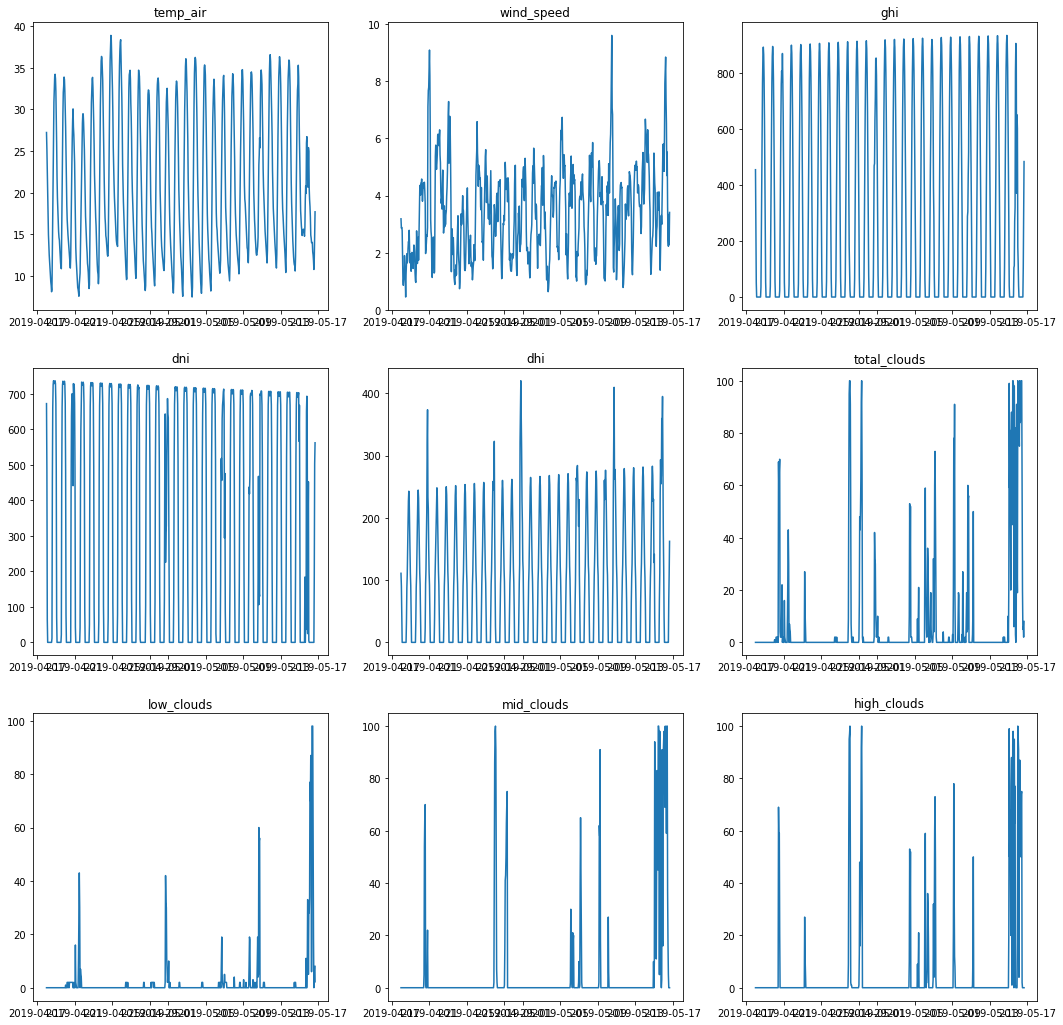

In [12]:
for im,m in enumerate(fd.keys()):
    fig = plt.figure(figsize=(18,18))
    print(im,m, len(fd[m]), ":")
    for it,c in enumerate(fd[m].columns):
        fig.add_subplot(3,3,it+1)
        plt.plot(fd[m].index,fd[m][c])
        plt.title(c)
        #fd[m][c].plot()
    plt.show()

Plot the GHI data. Most pvlib forecast models derive this data from the weather models' cloud clover data.

## Calculate modeling intermediates

Before we can calculate power for all the forecast times, we will need to calculate:
* solar position 
* extra terrestrial radiation
* airmass
* angle of incidence
* POA sky and ground diffuse radiation
* cell and module temperatures

The approach here follows that of the pvlib tmy_to_power notebook. You will find more details regarding this approach and the values being calculated in that notebook.

### Solar position

Calculate the solar position for all times in the forecast data. 

The default solar position algorithm is based on Reda and Andreas (2004). Our implementation is pretty fast, but you can make it even faster if you install [``numba``](http://numba.pydata.org/#installing) and use add  ``method='nrel_numba'`` to the function call below.

0 RAP :


/home/rodin/projects/pvlib-python/pvlib/solarposition.py:253: UserWarning: Reloading spa to use numba
  warnings.warn('Reloading spa to use numba')


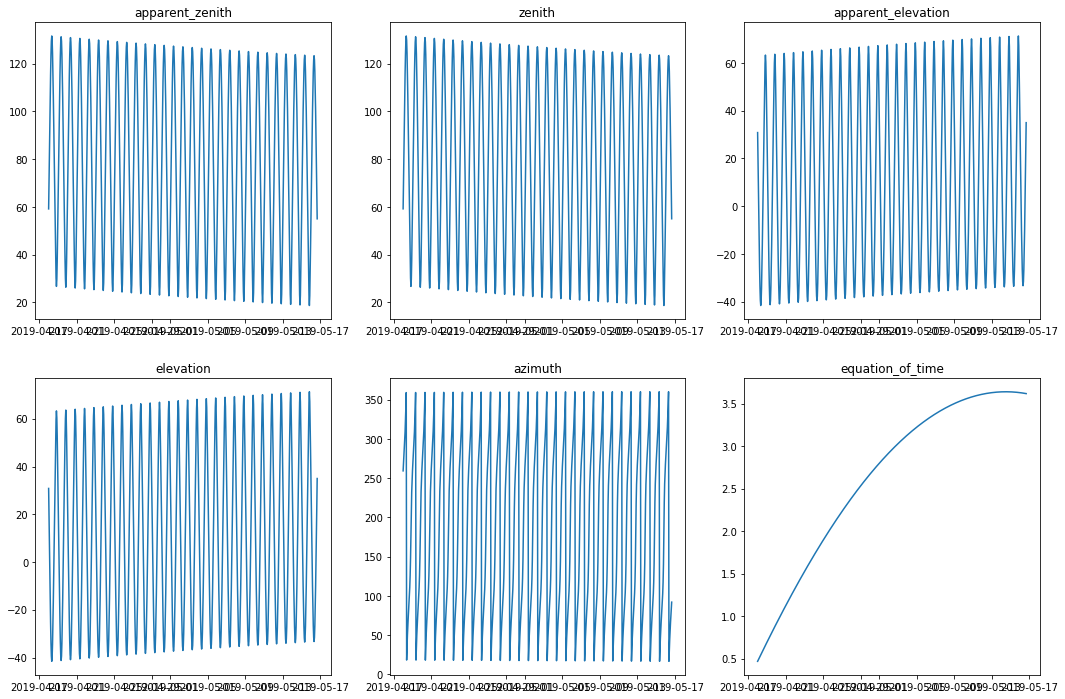

In [13]:
# retrieve dtime and location parameters
#fig = plt.figure(figsize=(5,20))
solpos = {}
for im,m in enumerate(fd.keys()):
    print(im,m,":")
    dtime = fd[m].index
    a_point = fm[m].location
    solpos[m] = a_point.get_solarposition(dtime,method='nrel_numba')
    fig = plt.figure(figsize=(18,12))
    for ic,c in enumerate(solpos[m].columns):
        fig.add_subplot(2,3,ic+1)
        plt.plot(dtime,solpos[m][c])
        plt.title(c)
    plt.show()

### DNI ET

Calculate extra terrestrial radiation. This is needed for many plane of array diffuse irradiance models.

RAP :


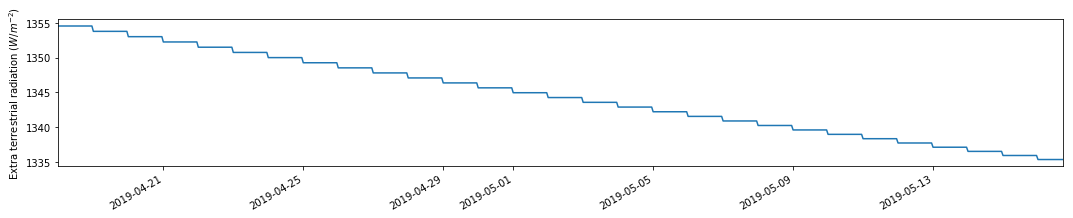

In [14]:
dni_extra = {}
for m in fd.keys():
    print(m, ":")
    dni_extra[m] = irradiance.get_extra_radiation(fm[m].time)
    fig = plt.figure(figsize=(18,3))
    dni_extra[m].plot()
    plt.ylabel('Extra terrestrial radiation ($W/m^{-2}$)')
    plt.show()

### Airmass

Calculate airmass. Lots of model options here, see the ``atmosphere`` module tutorial for more details.

RAP :


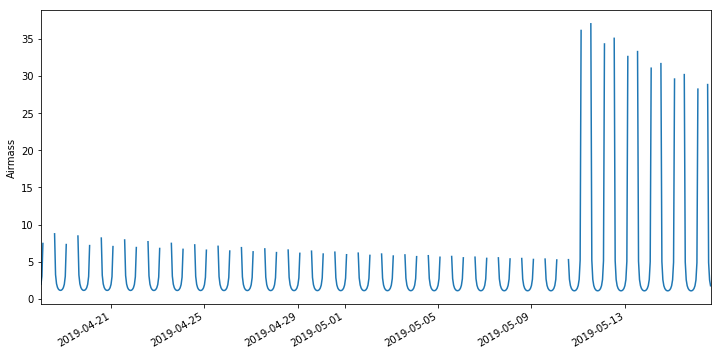

In [15]:
airmass = {}
for m in solpos.keys():
    print(m,":")
    airmass[m] = atmosphere.get_relative_airmass(solpos[m]['apparent_zenith'])
    fig = plt.figure(figsize=(12,6))
    airmass[m].plot()
    plt.ylabel('Airmass')
    plt.show()

The funny appearance is due to aliasing and setting invalid numbers equal to ``NaN``. Replot just a day or two and you'll see that the numbers are right.

### POA sky diffuse

Use the Hay Davies model to calculate the plane of array diffuse sky radiation. See the ``irradiance`` module tutorial for comparisons of different models.

0 RAP 689


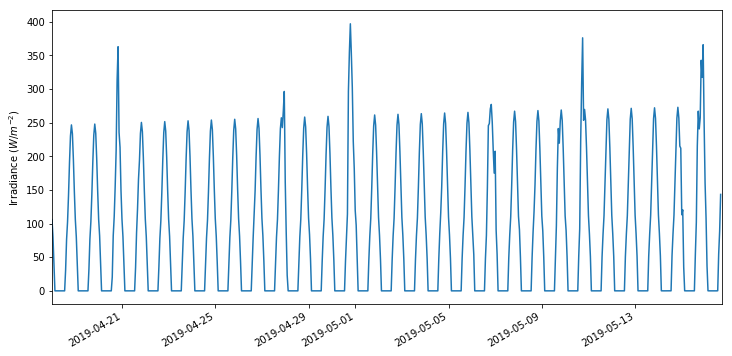

In [17]:
poa_sky_diffuse = {}

for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]))
    poa_sky_diffuse[m] = irradiance.haydavies(surface_tilt, surface_azimuth,
                                       fd[m]['dhi'], fd[m]['dni'], dni_extra[m],
                                       solpos[m]['apparent_zenith'], solpos[m]['azimuth'])
    fig = plt.figure(figsize=(12,6))
    poa_sky_diffuse[m].plot()
    plt.ylabel('Irradiance ($W/m^{-2}$)')
    plt.show()

### POA ground diffuse

Calculate ground diffuse. We specified the albedo above. You could have also provided a string to the ``surface_type`` keyword argument.

0 RAP 689 :


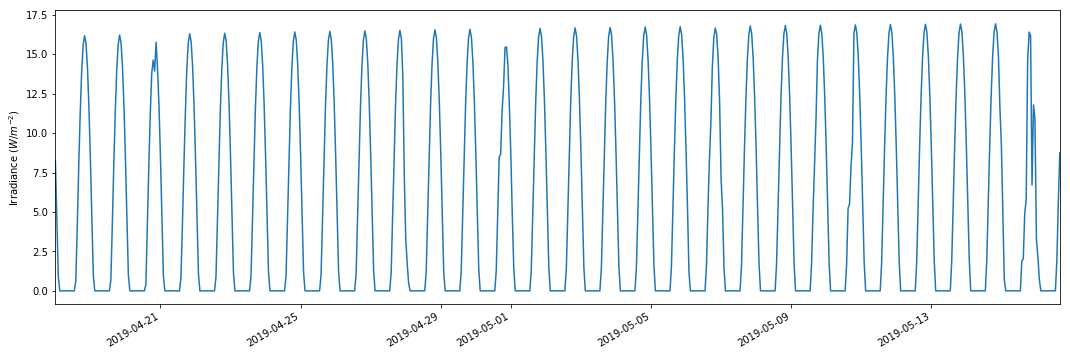

In [19]:
ia  = 0
poa_ground_diffuse = {}
for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]), ":")
    poa_ground_diffuse[m] = irradiance.get_ground_diffuse(surface_tilt, fd[m]['ghi'], albedo=albedo)
    figure = plt.figure(figsize=(18,6))
    poa_ground_diffuse[m].plot()
    plt.ylabel('Irradiance ($W/m^{-2}$)')
    plt.show()

### AOI

Calculate AOI

0 RAP 689 :


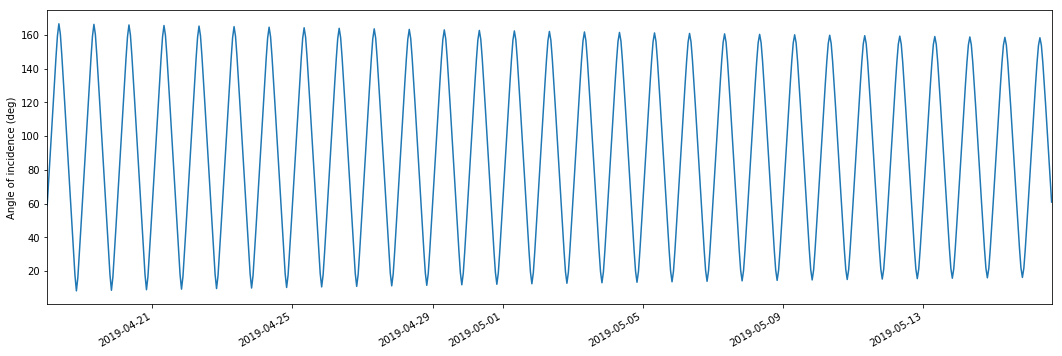

In [20]:

aoi = {}
for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]), ":")
    aoi[m] = irradiance.aoi(surface_tilt, surface_azimuth, solpos[m]['apparent_zenith'], solpos[m]['azimuth'])
    figure = plt.figure(figsize=(18,6))
    aoi[m].plot()
    plt.ylabel('Angle of incidence (deg)')
    plt.show()

Note that AOI has values greater than 90 deg. This is ok.

### POA total

Calculate POA irradiance

0 RAP 689 :


<Figure size 1296x216 with 0 Axes>

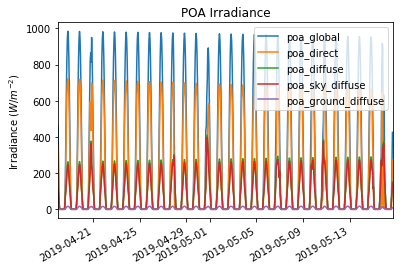

In [21]:
plt.close()
poa_irrad = {}
for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]),":")
    fig = plt.figure(figsize=(18,3))
    poa_irrad[m] = irradiance.poa_components(aoi[m], fd[m]['dni'], poa_sky_diffuse[m], poa_ground_diffuse[m])

    poa_irrad[m].plot()
    plt.ylabel('Irradiance ($W/m^{-2}$)')
    plt.title('POA Irradiance')
    plt.show()

### Cell and module temperature

Calculate pv cell and module temperature

0 RAP 689 :


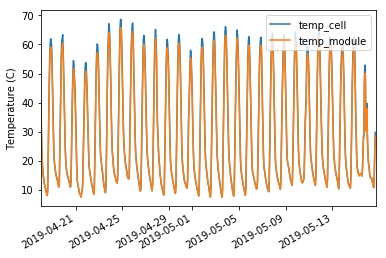

In [22]:
temperature = {}
wnd_spd = {}
pvtemps = {}
for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]), ":")
    temperature[m] = fd[m]['temp_air']
    wnd_spd[m] = fd[m]['wind_speed']
    pvtemps[m] = pvsystem.sapm_celltemp(poa_irrad[m]['poa_global'], wnd_spd[m], temperature[m])

    pvtemps[m].plot()
    plt.ylabel('Temperature (C)')
    plt.show()

## DC power using SAPM

Get module data from the web.

In [23]:
sandia_modules = pvsystem.retrieve_sam('SandiaMod')

In [24]:
# list modules
print(list(sandia_modules.keys()))

['Advent_Solar_AS160___2006_', 'Advent_Solar_Ventura_210___2008_', 'Advent_Solar_Ventura_215___2009_', 'Aleo_S03_160__2007__E__', 'Aleo_S03_165__2007__E__', 'Aleo_S16_165__2007__E__', 'Aleo_S16_170__2007__E__', 'Aleo_S16_175__2007__E__', 'Aleo_S16_180__2007__E__', 'Aleo_S16_185__2007__E__', 'AstroPower_AP_100___2001_', 'AstroPower_AP_100__2000__E__', 'AstroPower_AP_110___2001_', 'AstroPower_AP_110__1999__E__', 'AstroPower_AP_120___2001_', 'AstroPower_AP_120__1999__E__', 'AstroPower_AP_1206___1998_', 'AstroPower_AP_130___2001_', 'AstroPower_AP_130__2002__E__', 'AstroPower_AP_50___2001_', 'AstroPower_AP_50__2000__E__', 'AstroPower_AP_65__1999__E__', 'AstroPower_AP_75___2001_', 'AstroPower_AP_75___2003_', 'AstroPower_AP_75__2003__E__', 'AstroPower_AP_8225___1997_', 'AstroPower_APX_110_SL___2002_', 'AstroPower_APX_110_SL__2002__E__', 'AstroPower_APX_120___2001_', 'AstroPower_APX_120__2002__E__', 'AstroPower_APX_130___2001_', 'AstroPower_APX_130__2002__E__', 'AstroPower_APX_140__2002__E__',

Choose a particular module

In [25]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
#SunPower SPR-225-BLK [2007 (E)]
sandia_module = sandia_modules.SunPower_SPR_225_BLK__2007__E__
sandia_module

Vintage                                                      2007 (E)
Area                                                            1.244
Material                                                         c-Si
Cells_in_Series                                                    72
Parallel_Strings                                                    1
Isco                                                             5.87
Voco                                                             48.5
Impo                                                             5.49
Vmpo                                                               41
Aisc                                                           0.0006
Aimp                                                         -0.00038
C0                                                              1.004
C1                                                             -0.004
Bvoco                                                          -0.132
Mbvoc               

Run the SAPM using the parameters we calculated above.

0 RAP 689 :


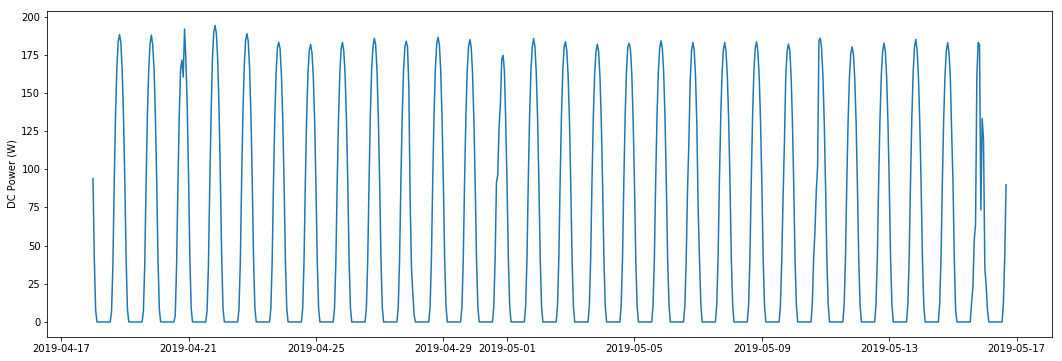

In [26]:
effective_irradiance = {}
sapm_out = {}
for im, m in enumerate(poa_irrad.keys()):
    print(im,m,len(fd[m]), ":")
    effective_irradiance[m] = pvsystem.sapm_effective_irradiance(poa_irrad[m].poa_direct, poa_irrad[m].poa_diffuse, 
                                                          airmass[m], aoi[m], sandia_module)

    sapm_out[m] = pvsystem.sapm(effective_irradiance[m], pvtemps[m]['temp_cell'], sandia_module)
    #print(sapm_out.head())
    plt.figure(figsize=(18,6))
    #sapm_out[m][['p_mp']].plot()
    plt.plot(sapm_out[m].index, sapm_out[m][['p_mp']])
    plt.ylabel('DC Power (W)')
    plt.show()

## AC power using SAPM

Get the inverter database from the web

In [27]:
sapm_inverters = pvsystem.retrieve_sam('sandiainverter')
#print(list(sapm_inverters.keys())) # uncomment to see full list of inverters.

Choose a particular inverter

In [28]:
sapm_inverter_7kw = sapm_inverters['SunPower__SPR_7000m__277V__277V__CEC_2018_']
sapm_inverter_6kw = sapm_inverters['SunPower__SPR_6000m__277V__277V__CEC_2018_']
sapm_inverter_5kw = sapm_inverters['SunPower__SPR_5000m__277V__277V__CEC_2018_']
print(sapm_inverter_5kw)
print(sapm_inverter_6kw)
print(sapm_inverter_7kw)

Vac           277.000000
Paco         5000.000000
Pdco         5213.480000
Vdco          310.000000
Pso            50.498100
C0             -0.000004
C1              0.000037
C2              0.001857
C3              0.001186
Pnt             1.410000
Vdcmax        480.000000
Idcmax         16.817700
Mppt_low      100.000000
Mppt_high     480.000000
Name: SunPower__SPR_5000m__277V__277V__CEC_2018_, dtype: float64
Vac           277.000000
Paco         6000.000000
Pdco         6269.200000
Vdco          310.000000
Pso            51.508600
C0             -0.000004
C1              0.000044
C2              0.001250
C3              0.000572
Pnt             1.410000
Vdcmax        480.000000
Idcmax         20.223200
Mppt_low      100.000000
Mppt_high     480.000000
Name: SunPower__SPR_6000m__277V__277V__CEC_2018_, dtype: float64
Vac           277.000000
Paco         7000.000000
Pdco         7344.340000
Vdco          310.000000
Pso            50.526900
C0             -0.000004
C1              0.00

### Inverter capacities

Let's just use 1 SP7000m, for ease of calculation.

In [29]:
max_i7k = 7000 // 225 
print(max_i7k)
max_i6k = 6000 // 225 
print(max_i6k)
max_i5k = 5000 // 225 #
print(max_i5k)

31
26
22


In [34]:
npanels = max_i7k + 10

0 RAP 689 :


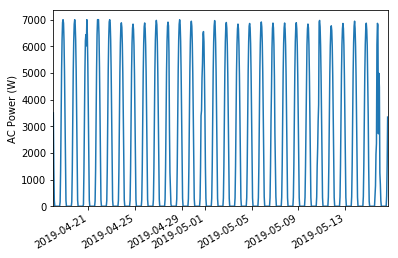

In [35]:
p_ac = {}
for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]), ":")
    p_ac[m] = pvsystem.snlinverter( npanels * sapm_out[m].v_mp, npanels * sapm_out[m].p_mp, sapm_inverter_7kw) 
    p_ac[m].plot()
    plt.ylabel('AC Power (W)')
    plt.ylim(0, None)
    plt.show()

Some statistics on the AC power

In [36]:
for m in p_ac.keys():
    print(m, ":")
    print(p_ac[m].describe())
    print(p_ac[m].index.freq)
    print(p_ac[m].sum()*3)
    print("\n")

RAP :
count     689.000000
mean     2120.905781
std      2654.721823
min        -1.410000
25%        -1.410000
50%       280.298832
75%      4969.013684
max      7000.000000
dtype: float64
None
4383912.249219517




In [37]:
p_ac['RAP']

2019-04-18 00:00:00+00:00           3502.761697
2019-04-18 01:00:00+00:00           1476.668647
2019-04-18 02:00:00.000013+00:00     210.189319
2019-04-18 03:00:00+00:00             -1.410000
2019-04-18 04:00:00+00:00             -1.410000
2019-04-18 05:00:00.000013+00:00      -1.410000
2019-04-18 06:00:00+00:00             -1.410000
2019-04-18 07:00:00+00:00             -1.410000
2019-04-18 08:00:00.000013+00:00      -1.410000
2019-04-18 09:00:00+00:00             -1.410000
2019-04-18 10:00:00+00:00             -1.410000
2019-04-18 11:00:00.000013+00:00      -1.410000
2019-04-18 12:00:00+00:00             -1.410000
2019-04-18 13:00:00+00:00             -1.410000
2019-04-18 14:00:00.000013+00:00     160.925868
2019-04-18 15:00:00+00:00           1328.470027
2019-04-18 16:00:00+00:00           3378.616086
2019-04-18 17:00:00.000013+00:00    5090.435284
2019-04-18 18:00:00+00:00           6253.071691
2019-04-18 19:00:00+00:00           6893.996992
2019-04-18 20:00:00.000013+00:00    7000

In [39]:
p_ac[m]

2019-04-18 00:00:00+00:00           3502.761697
2019-04-18 01:00:00+00:00           1476.668647
2019-04-18 02:00:00.000013+00:00     210.189319
2019-04-18 03:00:00+00:00             -1.410000
2019-04-18 04:00:00+00:00             -1.410000
2019-04-18 05:00:00.000013+00:00      -1.410000
2019-04-18 06:00:00+00:00             -1.410000
2019-04-18 07:00:00+00:00             -1.410000
2019-04-18 08:00:00.000013+00:00      -1.410000
2019-04-18 09:00:00+00:00             -1.410000
2019-04-18 10:00:00+00:00             -1.410000
2019-04-18 11:00:00.000013+00:00      -1.410000
2019-04-18 12:00:00+00:00             -1.410000
2019-04-18 13:00:00+00:00             -1.410000
2019-04-18 14:00:00.000013+00:00     160.925868
2019-04-18 15:00:00+00:00           1328.470027
2019-04-18 16:00:00+00:00           3378.616086
2019-04-18 17:00:00.000013+00:00    5090.435284
2019-04-18 18:00:00+00:00           6253.071691
2019-04-18 19:00:00+00:00           6893.996992
2019-04-18 20:00:00.000013+00:00    7000

In [40]:
p_ac[m].to_csv("modesto_solar_residential_7kw.csv")

/home/rodin/venv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Get Residential Site Data

Now that we have our solar data we need to get the residential data.

In [ ]:
# get residential site data here!

#...

In [ ]:
for im,m in enumerate(fd.keys()):
    print(im,m,len(fd[m]), ":")
    #print(p_ac[m].columns)
    ts = fd[m].index[0]
    te = fd[m].index[-1]
    fig = plt.figure(figsize=(24,9))
    print(ts.timestamp()," to ", te.timestamp())
    plt.plot(p_ac[m].index,p_ac[m]/1000, label=m)
    #plt.plot(df['datetime'],df['Generation_[kWh]'],label='DBC')
    plt.ylabel('AC Power [kW]')
    plt.title("Model {} and Residential Site Data".format(m))
    plt.ylim(0.5, None)
    plt.xlim(ts,te)
    plt.legend(loc='best')
    #plt.yscale('log')
    plt.show()